In [1]:
from sedona.spark import SedonaContext

config = (
    SedonaContext.builder()
    .config(
        "spark.jars.packages",
        ",".join([
            "org.apache.sedona:sedona-spark-shaded-3.5_2.12:1.7.1",
            "org.datasyslab:geotools-wrapper:1.7.0-28.5",
            "org.apache.hadoop:hadoop-aws:3.3.2"
        ])
    )
    .config("spark.jars.repositories", "https://artifacts.unidata.ucar.edu/repository/unidata-all")        
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "true") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
        "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .config("spark.executor.memory", "12G")
    .config("spark.driver.memory", "12G")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

sedona = SedonaContext.create(config)
sedona.sparkContext.setLogLevel("ERROR")

sedona.conf.set("fs.https.impl", "org.apache.hadoop.fs.http.HttpsFileSystem")

https://artifacts.unidata.ucar.edu/repository/unidata-all added as a remote repository with the name: repo-1
Ivy Default Cache set to: /Users/mattforrest/.ivy2/cache
The jars for the packages stored in: /Users/mattforrest/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-3.5_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cc0a348d-af6a-4720-96cd-ccfd0e29c9ac;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-shaded-3.5_2.12;1.7.1 in central
	found org.datasyslab#geotools-wrapper;1.7.0-28.5 in central
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 104ms :: artifacts dl 5ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.1026 from central in [default]
	org.a

:: loading settings :: url = jar:file:/Users/mattforrest/Documents/sedona-tutorial/.venv/lib/python3.13/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


25/05/22 12:27:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Part 1: Simple Example

## Create a Dataframe

In [ ]:
from pyspark.sql import Row

: 

In [ ]:
data = [
    Row(id=1, name="Point A", lat=40.7128, lon=-74.0060),
    Row(id=2, name="Point B", lat=34.0522, lon=-118.2437),
    Row(id=3, name="Point C", lat=37.7749, lon=-122.4194)
]

In [ ]:
df = sedona.createDataFrame(data)
df.show()

In [ ]:
from pyspark.sql.functions import expr

In [ ]:
df_geom = df.withColumn("geom", 
                        expr("ST_Point(cast(lon as Decimal(24, 20)), cast(lat as Decimal(24, 20)))"))

In [ ]:
df_geom.show(truncate=False)

## Simple Query

In [ ]:
sql = """
SELECT ST_AreaSpheroid(
    ST_GeomFromWKT('Polygon ((34 35, 28 30, 25 34, 34 35))')
) as result
"""

In [ ]:
sedona.sql(sql).show(truncate=False)

## Spatial Filter

In [ ]:
from pyspark.sql import Row

In [ ]:
data = [
    Row(id=1, name="Point A", lat=40.7128, lon=-74.0060),
    Row(id=2, name="Point B", lat=34.0522, lon=-118.2437),
    Row(id=3, name="Point C", lat=37.7749, lon=-122.4194)
]

In [ ]:
df = sedona.createDataFrame(data)
df.show()

In [ ]:
from pyspark.sql.functions import expr

In [ ]:
df_geom = df.withColumn("geom", expr("ST_Point(cast(lon as Decimal(24, 20)), cast(lat as Decimal(24, 20)))"))
df_geom.show(truncate=False)

In [ ]:
df_geom.createOrReplaceTempView("points")

In [ ]:
sedona.sql("""
SELECT id, name, ST_AsText(geom) AS wkt
FROM points
WHERE ST_Within(geom, ST_GeomFromText('POLYGON((-120 20, -60 20, -60 50, -120 50, -120 20))'))
""").show(truncate=False)

## Same as above, but Pythonic

In [ ]:
from sedona.sql.st_constructors import ST_GeomFromText
from sedona.sql.st_functions import ST_AsText
from sedona.sql.st_predicates import ST_Within
from pyspark.sql.functions import lit

In [ ]:
polygon_wkt = 'POLYGON((-120 20, -60 20, -60 50, -120 50, -120 20))'
polygon_geom = ST_GeomFromText(lit(polygon_wkt))

In [ ]:
df_filtered = df_geom.filter(
    ST_Within(df_geom["geom"], polygon_geom)). \
    select(
        "id", "name", ST_AsText("geom").alias("wkt")
    )

df_filtered.show(truncate=False)

# Part 2: Reading Vector Data

In [2]:
geojson_path = 'data/Neighborhood_Map_Atlas_Neighborhoods.geojson'
geojson_df = sedona.read.format("geojson").load(geojson_path)

In [3]:
geojson_df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- geometry: geometry (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- L_HOOD: string (nullable = true)
 |    |-- OBJECTID: long (nullable = true)
 |    |-- S_HOOD: string (nullable = true)
 |    |-- S_HOOD_ALT_NAMES: string (nullable = true)
 |    |-- Shape__Area: double (nullable = true)
 |    |-- Shape__Length: double (nullable = true)
 |-- type: string (nullable = true)



In [4]:
from pyspark.sql.functions import expr

In [5]:
geojson_df = (
    sedona.read.format("geojson").option("multiLine", "true").load(geojson_path)
    .selectExpr("explode(features) as features")
    .select("features.*")
    .withColumn("L_HOOD", expr("properties['L_HOOD']"))
    .withColumn("OBJECTID", expr("properties['OBJECTID']"))
    .withColumn("S_HOOD", expr("properties['S_HOOD']"))
    .withColumn("S_HOOD_ALT_NAMES", expr("properties['S_HOOD_ALT_NAMES']"))
    .drop("properties").drop("type")
)

In [6]:
geojson_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- L_HOOD: string (nullable = true)
 |-- OBJECTID: long (nullable = true)
 |-- S_HOOD: string (nullable = true)
 |-- S_HOOD_ALT_NAMES: string (nullable = true)



In [7]:
geojson_df.count()

94

In [8]:
df = (
    sedona.read.format("geopackage")
    .option("showMetadata", "true")
    .load("data/parks.gpkg")
)
df.show()

+----------+---------+----------+--------------------+--------------------+---------------+-----------------+-----------------+-----------------+------+
|table_name|data_type|identifier|         description|         last_change|          min_x|            min_y|            max_x|            max_y|srs_id|
+----------+---------+----------+--------------------+--------------------+---------------+-----------------+-----------------+-----------------+------+
|     parks| features| DPR.Parks|Locations of Seat...|2025-05-07 16:37:...|1244524.2382299|185216.9820538014|1292596.322203636|271529.3333788812|100000|
+----------+---------+----------+--------------------+--------------------+---------------+-----------------+-----------------+-----------------+------+



In [9]:
df = (
    sedona.read.format("geopackage")
    .option("tableName", "parks")
    .load("data/parks.gpkg")
)
df.show()

+---+--------------------+--------------------+--------------------+-----------------+----------+---------+----+-----+-----+-----+----+----------+--------+----------+-----------------+-----+----------+----------+----------+--------------------+
|fid|                geom|                NAME|            PMA_NAME|          ADDRESS|       PIN|SUBPARCEL| PMA|OWNER|LEASE|MAINT|USE_|  ACQ_DATE|NAMEFLAG|REVIEW_DAT|           AMWOID| SDQL|SE_ANNO_CA|GIS_CRT_DT|GIS_EDT_DT|            GlobalID|
+---+--------------------+--------------------+--------------------+-----------------+----------+---------+----+-----+-----+-----+----+----------+--------+----------+-----------------+-----+----------+----------+----------+--------------------+
|  1|MULTIPOLYGON (((1...|                NULL|                NULL|             NULL|2489200285|    16822|4463|  SPU|    N|  SPU|NULL|1899-12-30|       0|2011-03-09|   PROPERTY-MYRES|QL-D3|      NULL|2025-05-07|2025-05-07|dc828a5f-e037-4a5...|
|  2|MULTIPOLYGON ((

In [10]:
shapefile_path = 'data/parks/'
shapefile_df = sedona.read.format("shapefile").load(shapefile_path)

In [11]:
# CSV - https://www.kaggle.com/datasets/andykrause/kingcountysales
csv_path = 'data/kingco_sales.csv'
csv_df = sedona.read.format("csv").load(csv_path)
csv_df.show(3)

+----+---------+------------+----------+----------+--------+------------+-----------+---------+----------------+-----------------+----+-----------+-------+--------------------+-----------+--------+-------+----------+---------+--------+----+------+----------+-----+-----------+---------+-------+----+---------+---------+---------+---------+---------+----+----+---------+-------------+------------+-------------+-------------+----------------+------------+----------+-------------+-------------+---------------+----------+---------+
| _c0|      _c1|         _c2|       _c3|       _c4|     _c5|         _c6|        _c7|      _c8|             _c9|             _c10|_c11|       _c12|   _c13|                _c14|       _c15|    _c16|   _c17|      _c18|     _c19|    _c20|_c21|  _c22|      _c23| _c24|       _c25|     _c26|   _c27|_c28|     _c29|     _c30|     _c31|     _c32|     _c33|_c34|_c35|     _c36|         _c37|        _c38|         _c39|         _c40|            _c41|        _c42|      _c43|    

In [12]:
# Read CSV with header and inferSchema
csv_df = sedona.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(csv_path)

csv_df.show(3)

+---+---------+------------+----------+----------+--------+------------+-----------+---------+----------------+-----------------+----+-----------+-------+--------------------+-----------+--------+-------+----------+---------+--------+----+------+----------+-----+-----------+---------+-------+----+---------+---------+---------+---------+---------+----+----+---------+-------------+------------+-------------+-------------+----------------+------------+----------+-------------+-------------+---------------+----------+---------+
|_c0|  sale_id|        pinx| sale_date|sale_price|sale_nbr|sale_warning|join_status|join_year|        latitude|        longitude|area|       city| zoning|         subdivision|present_use|land_val|imp_val|year_built|year_reno|sqft_lot|sqft|sqft_1|sqft_fbsmt|grade|fbsmt_grade|condition|stories|beds|bath_full|bath_3qtr|bath_half|garb_sqft|gara_sqft|wfnt|golf|greenbelt|noise_traffic|view_rainier|view_olympics|view_cascades|view_territorial|view_skyline|view_sound|view_l

In [13]:
from pyspark.sql.functions import col

In [14]:
csv_df = csv_df.selectExpr(
    "*", "ST_Point(longitude, latitude) as geometry")

In [15]:
csv_df.show(3)

+---+---------+------------+----------+----------+--------+------------+-----------+---------+----------------+-----------------+----+-----------+-------+--------------------+-----------+--------+-------+----------+---------+--------+----+------+----------+-----+-----------+---------+-------+----+---------+---------+---------+---------+---------+----+----+---------+-------------+------------+-------------+-------------+----------------+------------+----------+-------------+-------------+---------------+----------+---------+--------------------+
|_c0|  sale_id|        pinx| sale_date|sale_price|sale_nbr|sale_warning|join_status|join_year|        latitude|        longitude|area|       city| zoning|         subdivision|present_use|land_val|imp_val|year_built|year_reno|sqft_lot|sqft|sqft_1|sqft_fbsmt|grade|fbsmt_grade|condition|stories|beds|bath_full|bath_3qtr|bath_half|garb_sqft|gara_sqft|wfnt|golf|greenbelt|noise_traffic|view_rainier|view_olympics|view_cascades|view_territorial|view_skyl

In [16]:
csv_df.count()

591513

In [17]:
# GeoParquet
geoparquet_path = 'data/Seattle_Transportation_Plan_Bicycle_Element_829016546957421557.parquet'
geoparquet_df = sedona.read.format("geoparquet").load(geoparquet_path)
geoparquet_df.show(3)

+--------+--------------+---------------------+--------------------+-------+-----------+
|OBJECTID| artclass_desc|bike_network_category|            geometry|     id| stname_ord|
+--------+--------------+---------------------+--------------------+-------+-----------+
|     1.0|Not Designated| Proposed Bike+ - ...|LINESTRING (-122....|23677.0| E ALDER ST|
|     2.0|Not Designated| Proposed Bike+ - ...|LINESTRING (-122....|20052.0| NE 55TH ST|
|     3.0|Not Designated| Proposed Bike+ - ...|LINESTRING (-122....| 5667.0|23RD AVE NW|
+--------+--------------+---------------------+--------------------+-------+-----------+
only showing top 3 rows



In [18]:
geoparquet_df.selectExpr('ST_SRID(geometry)').show(1)

+-----------------+
|st_srid(geometry)|
+-----------------+
|                0|
+-----------------+
only showing top 1 row



In [19]:
geoparquet_df.selectExpr('''ST_Transform(geometry, 'EPSG:2926', 'EPSG:4326')''').show(1)

+--------------------------------------------+
|st_transform(geometry, EPSG:2926, EPSG:4326)|
+--------------------------------------------+
|                        LINESTRING (-127....|
+--------------------------------------------+
only showing top 1 row



In [20]:
# GeoParquet
geoparquet_schools_path = 'data/Seattle_Public_Schools_Sites_2023-2024.parquet'
geoparquet_schools_df = sedona.read.format("geoparquet").load(geoparquet_schools_path)
geoparquet_schools_df.show(3)

+----------------+-----------------+--------+-------------------+------+--------------------+------+--------------+---------+--------------+------+-----------+-------+
|        Latitude|        Longitude|OBJECTID|            address|esmshs|            geometry|grades|      mapLabel|school_ID|   school_name|siteID|     status|    zip|
+----------------+-----------------+--------+-------------------+------+--------------------+------+--------------+---------+--------------+------+-----------+-------+
| 47.709950686514|-122.293023646655|     1.0| 11051 34th Ave. NE|    MS|POINT (-122.29300...|   6-8|   Jane Addams|    106.0|Jane Addams MS| 106.0|         MS|98125.0|
|47.7134360540258|-122.314672965205|     2.0| 11530 12th Ave. NE|    ES|POINT (-122.31465...|   K-8|Hazel Wolf K-8|    292.0|Hazel Wolf K-8| 263.0|Option ELEM|98125.0|
|47.4988691374883|-122.263186633228|     3.0|11650 Beacon Ave. S|    ES|POINT (-122.26317...|   K-5|  Rainier View|    264.0|  Rainier View| 264.0|       ELEM|9

# Part 3: Loading Raster Data

In [21]:
netcdf_file = "data/pdsi_current_PRISM.nc"
netcdf_df = sedona.read.format("binaryFile").load(netcdf_file)
netcdf_df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/Users/mattf...|2025-05-22 11:10:...|3499588|[43 44 46 01 00 0...|
+--------------------+--------------------+-------+--------------------+



In [22]:
import pyspark.sql.functions as f

In [23]:
netcdf_df.repartition(8)

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [24]:
netcdf_df = netcdf_df.withColumn("raster", f.expr("RS_FromNetCDF(content, 'data', 'longitude', 'latitude')"))

In [25]:
netcdf_df.show()

+--------------------+--------------------+-------+--------------------+--------------------+
|                path|    modificationTime| length|             content|              raster|
+--------------------+--------------------+-------+--------------------+--------------------+
|file:/Users/mattf...|2025-05-22 11:10:...|3499588|[43 44 46 01 00 0...|GridCoverage2D["g...|
+--------------------+--------------------+-------+--------------------+--------------------+



In [26]:
# https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_10TET_20250423_0_L2A?.asset=asset-nir

## GeoTIFF

In [27]:
# https://browser.apex.esa.int/external/eoresults.esa.int/stac/collections/ESA_WORLDCOVER_10M_2021_V2/items/ESA_WorldCover_10m_2021_v200_N45W123?.asset=asset-esa_worldcover_10m_map

In [28]:
raster_df = sedona.read.format("binaryFile") \
    .load("data/ESA_WorldCover_10m_2021_v200_N45W123_Map.tif")

In [29]:
raster_df = raster_df.withColumn("raster", f.expr("RS_FromGeoTiff(content)"))

In [30]:
# raster_df.show()

In [31]:
raster_df.repartition(8)

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary, raster: udt]

In [32]:
raster_df.selectExpr("RS_TileExplode(raster, 256, 256) as (x, y, raster)").show()

+---+---+--------------------+
|  x|  y|              raster|
+---+---+--------------------+
|  0|  0|GridCoverage2D["g...|
|  1|  0|GridCoverage2D["g...|
|  2|  0|GridCoverage2D["g...|
|  3|  0|GridCoverage2D["g...|
|  4|  0|GridCoverage2D["g...|
|  5|  0|GridCoverage2D["g...|
|  6|  0|GridCoverage2D["g...|
|  7|  0|GridCoverage2D["g...|
|  8|  0|GridCoverage2D["g...|
|  9|  0|GridCoverage2D["g...|
| 10|  0|GridCoverage2D["g...|
| 11|  0|GridCoverage2D["g...|
| 12|  0|GridCoverage2D["g...|
| 13|  0|GridCoverage2D["g...|
| 14|  0|GridCoverage2D["g...|
| 15|  0|GridCoverage2D["g...|
| 16|  0|GridCoverage2D["g...|
| 17|  0|GridCoverage2D["g...|
| 18|  0|GridCoverage2D["g...|
| 19|  0|GridCoverage2D["g...|
+---+---+--------------------+
only showing top 20 rows



# Part 4: PySpark and SparkSQL

In [ ]:
shapefile_df.printSchema()

In [ ]:
csv_df.printSchema()

In [ ]:
shapefile_df.selectExpr('ST_SRID(geometry)').first()

In [ ]:
csv_df.selectExpr('ST_SRID(geometry)').first()

In [ ]:
shapefile_df.createOrReplaceTempView("polygons")
csv_df.createOrReplaceTempView("points")

In [ ]:
%%time
sedona.sql("""
    SELECT p.sale_id AS point_id, poly.NAME AS park_name
    FROM points p
    JOIN polygons poly
    ON ST_DWithin(
        ST_Transform(poly.geometry, 'EPSG:2926', 'EPSG:26910'), 
        ST_Transform(p.geometry, 'EPSG:4326', 'EPSG:26910'), 
    30)
""").count()

In [ ]:
from pyspark.sql.functions import expr

# Transform geometries to EPSG:26910 (UTM zone), then apply ST_DWithin
transformed_points = csv_df.withColumn(
    "geom_utm", expr("ST_Transform(geometry, 'EPSG:4326', 'EPSG:26910')")
)

transformed_polygons = shapefile_df.withColumn(
    "geom_utm", expr("ST_Transform(geometry, 'EPSG:2926', 'EPSG:26910')")
)

# Perform spatial join using ST_DWithin
joined_df = transformed_points.alias("p").join(
    transformed_polygons.alias("poly"),
    expr("ST_DWithin(poly.geom_utm, p.geom_utm, 30)")
)

# Count matching pairs
joined_df.count()

# Part 5: DataFrame Operations

In [ ]:
csv_df.show(5, truncate=False)

In [ ]:
csv_df.printSchema()

In [ ]:
csv_df.select("sale_id", "sale_price").show()

In [ ]:
csv_df.count()

In [ ]:
points_df = csv_df.select("sale_id", "sale_price")

In [ ]:
points_df.first()

In [ ]:
points_df = csv_df.select("sale_id", "sale_price")

In [ ]:
points_df.orderBy("sale_price").show()

In [ ]:
points_df.filter("sale_price > 500000").show()

# Part 6: Vector and Raster Viz

,raster_image
0,

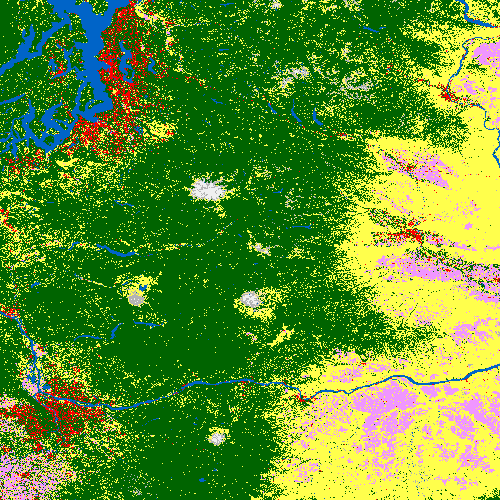

In [33]:
from sedona.spark import SedonaUtils

# Convert raster to base64 image for inline visualization
htmlDF = raster_df.selectExpr("RS_AsImage(raster, 500) as raster_image")

# Display in notebook (Jupyter or Databricks)
SedonaUtils.display_image(htmlDF)

In [34]:
from sedona.spark import SedonaKepler

map = SedonaKepler.create_map()
SedonaKepler.add_df(map, geoparquet_schools_df, name="Seattle Schools")
map

: 

# Part 7: Vector Functions

In [35]:
from sedona.sql.st_functions import ST_Buffer, ST_Transform, ST_ConvexHull

: 

In [36]:
from pyspark.sql.functions import col, lit

buffered_df = geoparquet_schools_df.select(
    ST_Buffer(
        ST_Transform(col("geometry"), lit("EPSG:4326"), lit("EPSG:26910")),
        100
    ).alias("buffer")
)

buffered_df.show(3)

In [37]:
map = SedonaKepler.create_map()
SedonaKepler.add_df(map, buffered_df, name="Seattle Schools Buffer")
map

In [38]:
schools_df = geoparquet_schools_df.selectExpr("*", "ST_Transform(geometry, 'EPSG:4326', 'EPSG:26910') as geom") \
    .drop("geometry") \
    .withColumnRenamed("geom", "geometry")

In [39]:
shapefile_df.createOrReplaceTempView('parks')

In [40]:
centroid = sedona.sql('''select st_centroid(geometry) from parks''')
centroid.show(3)

In [41]:
area = sedona.sql('''select st_area(geometry) from parks''')
area.show(3)

In [42]:
geoparquet_df.createOrReplaceTempView('bikes')

In [43]:
length = sedona.sql('''select st_length(geometry) from bikes''')
length.show(3)

In [44]:
hull_df = shapefile_df.select(
    "geometry",
    ST_ConvexHull("geometry").alias("convex_hull")
)
hull_df.show(3)

In [45]:
# Space Needle - -122.3494692, 47.6205426

In [46]:
from pyspark.sql.functions import lit

dist_df = sedona.sql('''
select ST_Distance(geometry, ST_Transform(ST_SetSRID(ST_Point(-122.3494692, 47.6205426), 4326), 'EPSG:26910')) as distance
from parks
''')

dist_df.show(3)

In [47]:
h3_df = sedona.sql('''
select ST_H3CellIDs(geometry, 8, true) as h3
from parks
limit 3
''')

h3_df.show()

In [48]:
sedona.sql("""
SELECT ST_3DDistance(
    ST_GeomFromText('POINT Z (0 0 0)'),
    ST_GeomFromText('POINT Z (3 4 12)')
) AS dist_3d
""").show()

# Part 8: Spatial Predicates

In [ ]:
csv_df.createOrReplaceTempView('homes')
geojson_df.createOrReplaceTempView('neighborhoods')

In [ ]:
geojson_df.show(3)

In [ ]:
sedona.sql('''
select h.sale_id, st_contains(n.geometry, h.geometry) in_ballard
from homes h
join neighborhoods n on st_contains(n.geometry, h.geometry)
where n.S_HOOD = 'Ballard'
''').show(3)

In [ ]:
sedona.sql('''
select h.sale_id
from homes h
join neighborhoods n on st_dwithin(
    st_transform(n.geometry, 'EPSG:4326', 'EPSG:26910'), 
    st_transform(h.geometry, 'EPSG:4326', 'EPSG:26910'),
    500)
where n.S_HOOD = 'Ballard'
''').count()

In [ ]:
sedona.sql('''SELECT ST_Contains(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(5 5)')
) AS contains
''').show()

In [ ]:
sedona.sql('''SELECT ST_Contains(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(0 0)')
) AS contains
''').show()

In [ ]:
sedona.sql('''SELECT ST_Intersects(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('LINESTRING(5 5, 15 5)')
) AS intersects''').show()

In [ ]:
sedona.sql('''SELECT ST_Intersects(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(0 0)')
) AS intersects
''').show()

In [ ]:
sedona.sql('''SELECT ST_Touches(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(0 0)')
) AS intersects
''').show()

In [ ]:
sedona.sql('''SELECT ST_Touches(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(5 5)')
) AS intersects
''').show()

# Part 9: Write Data

In [ ]:
# Write a single GeoJSON file (e.g., for download or web map use)
geojson_output_path = "parks.geojson"

shapefile_df.coalesce(1).write \
    .mode("overwrite") \
    .format("geojson") \
    .save(geojson_output_path)

In [ ]:
# Repartition to 10 files for parallel writes
csv_df.repartition(10).write \
    .mode("overwrite") \
    .format("geoparquet") \
    .save("data/output_geoparquet_10_parts")

In [ ]:
csv_df.write \
    .mode("overwrite") \
    .format("geoparquet") \
    .partitionBy("city") \
    .save("data/output_geoparquet_partitioned")

In [ ]:
# output_df.write \
#     .mode("overwrite") \
#     .format("geoparquet") \
#     .save("s3a://your-bucket-name/path/to/output/")

# Part 10: Nearest Neighbor Join

In [ ]:
geoparquet_schools_df.repartition(8)

: 

In [ ]:
geoparquet_schools_df.createOrReplaceTempView('schools')

In [ ]:
nearest = sedona.sql('''
select schools.school_name, parks.NAME
from schools
join parks on ST_KNN(
    schools.geometry,
    parks.geometry,
    3,
    true
)
''')

In [ ]:
nearest.show(9)

# Part 11: Raster Functions

In [ ]:
sample_area = 'POLYGON((-122.367948 47.642361, -122.361745 47.642361, -122.361745 47.638922, -122.367948 47.638922, -122.367948 47.642361))'

In [ ]:
raster_df.createOrReplaceTempView('landcover')

In [ ]:
centroids = sedona.sql(f'''
select RS_PixelAsCentroids(raster, 1)
from landcover
where rs_intersects(raster, st_geomfromtext('{sample_area}'))
''')

In [ ]:
centroids.show(3)

In [ ]:
raster_df.createOrReplaceTempView('landcover')

In [ ]:
values = sedona.sql(f'''
select RS_Value(raster, ST_Point(-122.373894, 47.634587))
from landcover
where rs_intersects(raster, st_geomfromtext('{sample_area}'))
''')

In [ ]:
%%time
values.show()

In [ ]:
raster_tiles = raster_df.selectExpr("RS_TileExplode(raster, 256, 256) as (x, y, raster)")

In [ ]:
raster_tiles.createOrReplaceTempView('landcover_tiles')

In [ ]:
raster_tiles.show()

In [ ]:
stats = sedona.sql('''SELECT RS_SummaryStatsAll(raster) AS stats
FROM landcover_tiles
where x = 0 and y = 0''')
stats.show(truncate=False)

In [ ]:
metadata = sedona.sql('''SELECT RS_MetaData(raster) AS stats
FROM landcover_tiles
where x = 0 and y = 0''')
metadata.show(truncate=False)

# Part 12: Raster Map Algerbra (NDVI)

In [ ]:
# # https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_10TET_20250423_0_L2A?.asset=asset-nir

In [ ]:
SELECT RS_MapAlgebra(rast, 'D', 'out = (rast[3] - rast[0]) / (rast[3] + rast[0]);') as ndvi FROM raster_table